In [ ]:

!pip install coral_pytorch


In [ ]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from coral_pytorch.losses import CoralLoss, CornLoss


In [ ]:

# ==========================================
# 2. Load Your Data
# ==========================================
# Ensure 'training_data.csv' and 'training_features.csv' are uploaded!
df_text = pd.read_csv("training_data.csv")
df_feats = pd.read_csv("training_features.csv")

# Clean up columns if needed
for col in ['labels', 'label', 'fold']:
    if col in df_feats.columns: df_feats = df_feats.drop(columns=[col])

df = pd.concat([df_text, df_feats], axis=1)

# The EXACT 24 features from your thesis
feature_cols = [
    'sent_len_tokens_mean', 'sent_len_tokens_max', 'token_len_chars_mean', 'token_len_chars_max',
    'mattr', 'lexical_density', 'noun_ratio', 'verb_ratio', 'adj_ratio', 'pron_ratio',
    'function_word_ratio', 'clauses_per_sentence', 'avg_tree_depth', 'ari', 'fres', 'smog', 'cli',
    'sp_rate', 'gr_rate', 'ratio_a1', 'ratio_a2', 'ratio_b1', 'ratio_b2', 'ratio_c1'
]

scaler = StandardScaler()
X = scaler.fit_transform(df[feature_cols].values)
y = torch.tensor(df['labels'].values, dtype=torch.long)
X_t = torch.tensor(X, dtype=torch.float32)


def label_to_levels(label, num_classes):
    """Converts integer labels (0, 1, 2) to binary ordinal vectors ([1,1,0...])"""
    # Create thresholds [0, 1, ..., K-2]
    thresholds = torch.arange(num_classes - 1).unsqueeze(0).to(label.device)
    # Expand labels to [N, 1]
    label_g = label.unsqueeze(1)
    # Comparison: Is label > threshold?
    return (label_g > thresholds).float()

# Create special targets for CORAL (Shape: [1138, 7])
y_coral = label_to_levels(y, num_classes=8)

In [ ]:
# ==========================================
# 3. Define Models (FIXED FeatureCORN)
# ==========================================
class FeatureCORAL(nn.Module):
    def __init__(self, input_dim, num_classes=8):
        super(FeatureCORAL, self).__init__()
        self.linear = nn.Linear(input_dim, 1, bias=False)
        self.biases = nn.Parameter(torch.zeros(num_classes - 1))

    def forward(self, x):
        return self.linear(x) + self.biases

class FeatureCORN(nn.Module):
    def __init__(self, input_dim, num_classes=8):
        super(FeatureCORN, self).__init__()
        self.classifiers = nn.ModuleList([nn.Linear(input_dim, 1) for _ in range(num_classes - 1)])

    def forward(self, x):
        # FIX: Concatenate the list of logits into a single tensor [Batch, Tasks]
        logits = [clf(x) for clf in self.classifiers]
        return torch.cat(logits, dim=1)

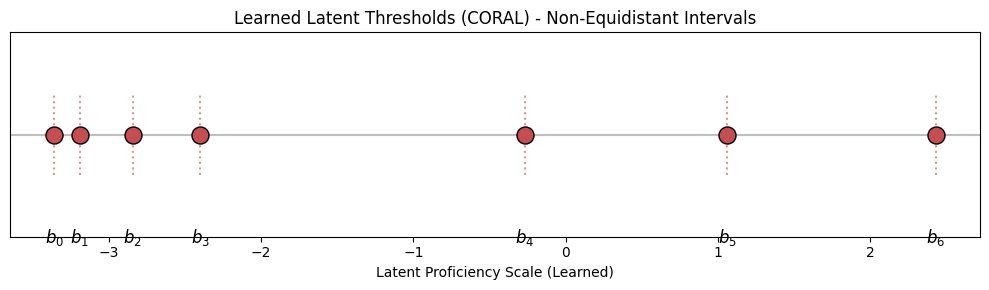

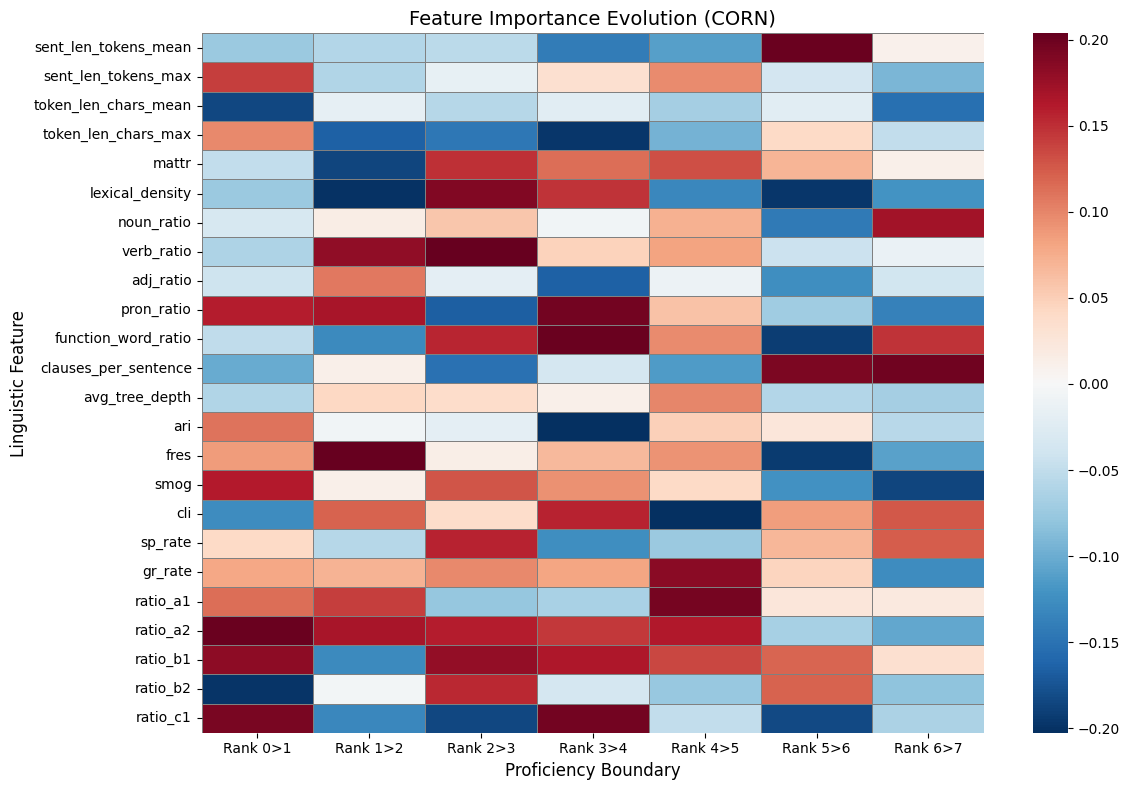

In [ ]:

# ==========================================
# 5. GENERATE PLOTS
# ==========================================

# --- PLOT A: CORAL Thresholds ---
biases = coral_model.biases.detach().numpy()
thresholds = np.sort(-biases) # Invert because T = -bias

plt.figure(figsize=(10, 3))
plt.title("Learned Latent Thresholds (CORAL) - Non-Equidistant Intervals", fontsize=12)
plt.axhline(0, color='gray', zorder=1, alpha=0.5)
plt.scatter(thresholds, np.zeros_like(thresholds), s=150, c='#c44e52', zorder=2, edgecolors='black')

# Annotate
for i, t in enumerate(thresholds):
    plt.text(t, -0.05, f'$b_{i}$', ha='center', va='top', fontsize=12, fontweight='bold')
    plt.axvline(t, ymin=0.3, ymax=0.7, color='#c44e52', linestyle=':', alpha=0.6)

plt.yticks([])
plt.xlabel("Latent Proficiency Scale (Learned)", fontsize=10)
plt.tight_layout()
plt.show()

# --- PLOT B: CORN Heatmap ---
# Extract weights [7, 24]
weights = np.array([clf.weight.detach().numpy().flatten() for clf in corn_model.classifiers])

plt.figure(figsize=(12, 8))
# Transpose so Features are Y-axis
sns.heatmap(weights.T, cmap="RdBu_r", center=0,
            xticklabels=[f"Rank {i}>{i+1}" for i in range(7)],
            yticklabels=feature_cols,
            linewidths=0.5, linecolor='gray')

plt.title("Feature Importance Evolution (CORN)", fontsize=14)
plt.xlabel("Proficiency Boundary", fontsize=12)
plt.ylabel("Linguistic Feature", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# ==========================================
# 1. Install & Setup
# ==========================================
!pip install coral_pytorch

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from coral_pytorch.losses import CoralLoss, CornLoss

# ==========================================
# 2. Load Your Data
# ==========================================
df_text = pd.read_csv("training_data.csv")
df_feats = pd.read_csv("training_features.csv")



In [ ]:


# Clean columns
for col in ['labels', 'label', 'fold']:
    if col in df_feats.columns: df_feats = df_feats.drop(columns=[col])

df = pd.concat([df_text, df_feats], axis=1)

# Feature List
feature_cols = [
    'sent_len_tokens_mean', 'sent_len_tokens_max', 'token_len_chars_mean', 'token_len_chars_max',
    'mattr', 'lexical_density', 'noun_ratio', 'verb_ratio', 'adj_ratio', 'pron_ratio',
    'function_word_ratio', 'clauses_per_sentence', 'avg_tree_depth', 'ari', 'fres', 'smog', 'cli',
    'sp_rate', 'gr_rate', 'ratio_a1', 'ratio_a2', 'ratio_b1', 'ratio_b2', 'ratio_c1'
]

# Prepare Data
scaler = StandardScaler()
X = scaler.fit_transform(df[feature_cols].values)
y = torch.tensor(df['labels'].values, dtype=torch.long)
X_t = torch.tensor(X, dtype=torch.float32)

# CORAL Target Helper
def label_to_levels(label, num_classes):
    thresholds = torch.arange(num_classes - 1).unsqueeze(0).to(label.device)
    label_g = label.unsqueeze(1)
    return (label_g > thresholds).float()

y_coral = label_to_levels(y, num_classes=8)

# ==========================================
# 3. Define Models
# ==========================================
class FeatureCORAL(nn.Module):
    def __init__(self, input_dim, num_classes=8):
        super(FeatureCORAL, self).__init__()
        self.linear = nn.Linear(input_dim, 1, bias=False)
        self.biases = nn.Parameter(torch.zeros(num_classes - 1))

    def forward(self, x):
        return self.linear(x) + self.biases

class FeatureCORN(nn.Module):
    def __init__(self, input_dim, num_classes=8):
        super(FeatureCORN, self).__init__()
        self.classifiers = nn.ModuleList([nn.Linear(input_dim, 1) for _ in range(num_classes - 1)])

    def forward(self, x):
        logits = [clf(x) for clf in self.classifiers]
        return torch.cat(logits, dim=1)


In [ ]:

# ==========================================
# 4. Quick Re-Training (30 Seconds)
# ==========================================
print("Training CORAL...")
coral_model = FeatureCORAL(len(feature_cols))
opt_coral = optim.Adam(coral_model.parameters(), lr=0.05)
criterion_coral = CoralLoss()

for _ in range(100):
    opt_coral.zero_grad()
    logits = coral_model(X_t)
    loss = criterion_coral(logits, y_coral)
    loss.backward()
    opt_coral.step()

print("Training CORN...")
corn_model = FeatureCORN(len(feature_cols))
opt_corn = optim.Adam(corn_model.parameters(), lr=0.05)
criterion_corn = CornLoss(num_classes=8)

for _ in range(100):
    opt_corn.zero_grad()
    logits = corn_model(X_t)
    loss = criterion_corn(logits, y)
    loss.backward()
    opt_corn.step()

# ==========================================
# 5. GENERATE ALL 4 PLOTS
# ==========================================
# Set global style


Training CORAL...
Training CORN...


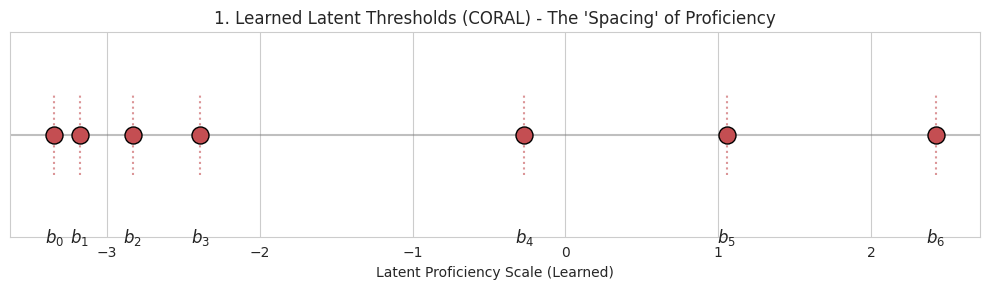

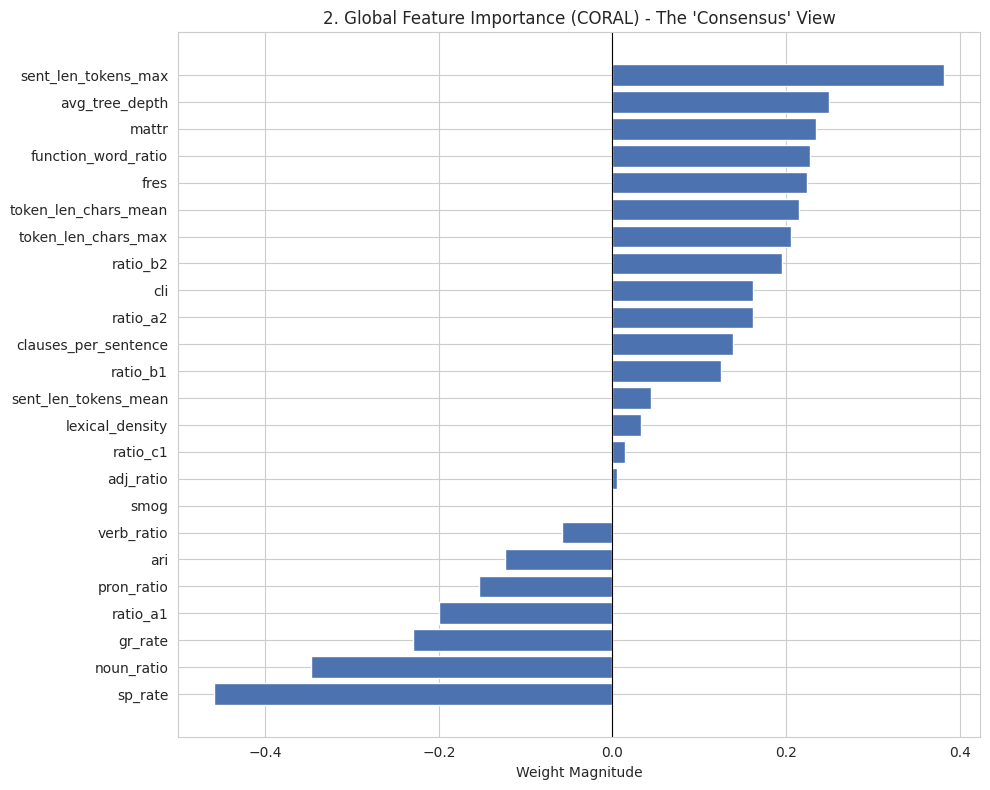

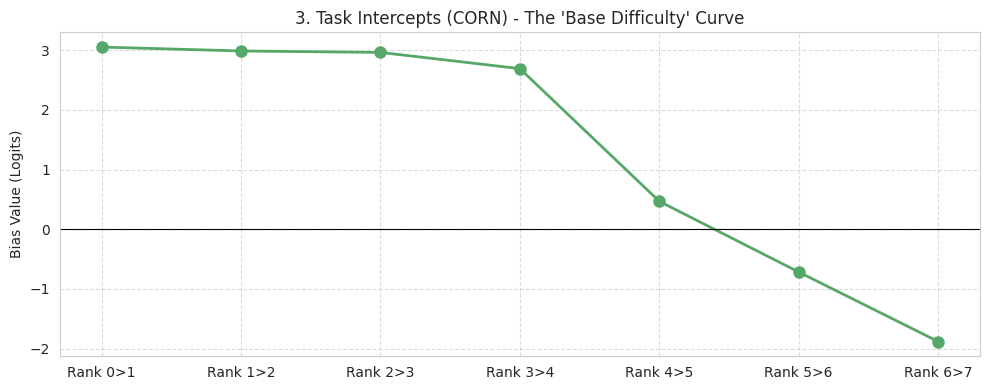

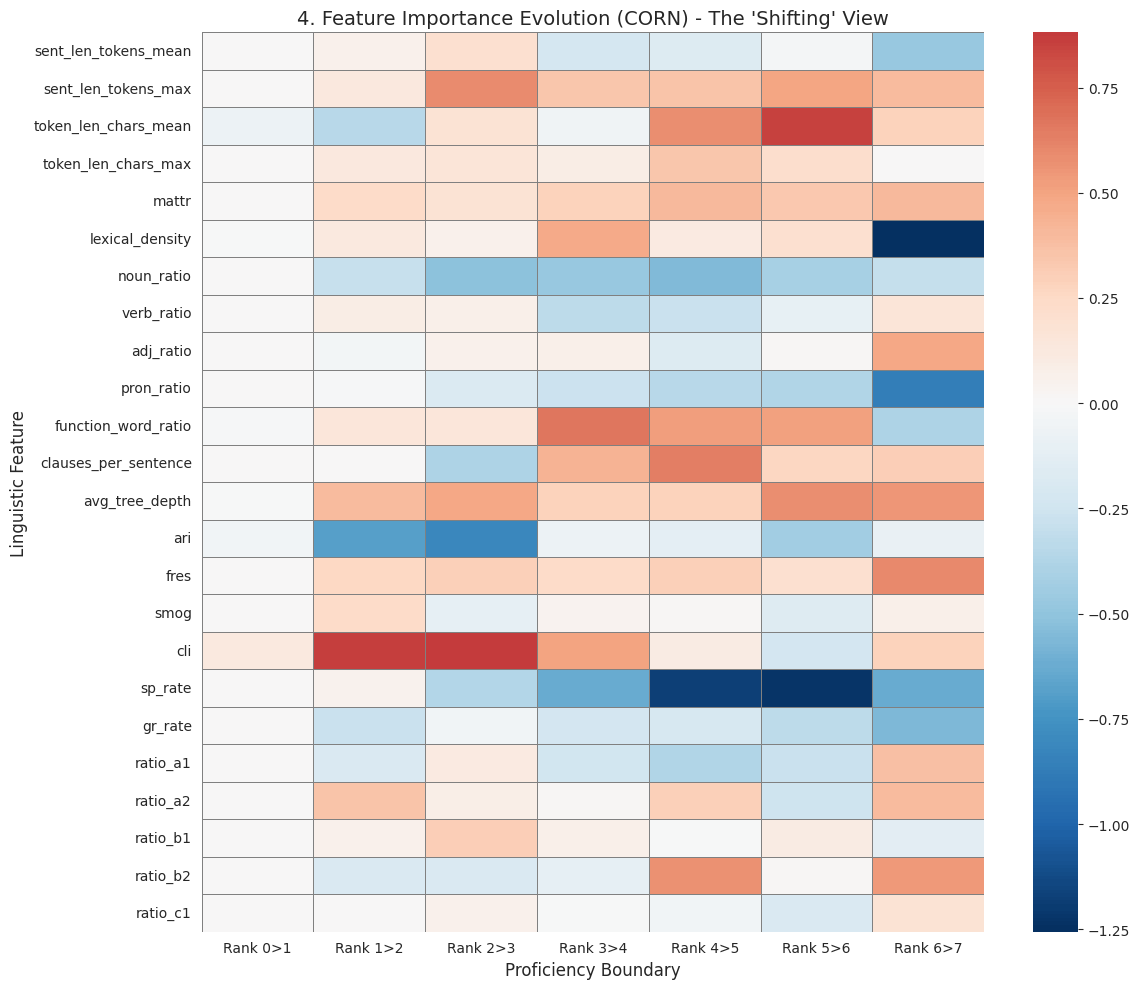

In [ ]:
sns.set_style("whitegrid")

# --- PLOT 1: CORAL THRESHOLDS (Latent Scale) ---
biases = coral_model.biases.detach().numpy()
thresholds = np.sort(-biases)

plt.figure(figsize=(10, 3))
plt.title("1. Learned Latent Thresholds (CORAL) - The 'Spacing' of Proficiency", fontsize=12)
plt.axhline(0, color='gray', zorder=1, alpha=0.5)
plt.scatter(thresholds, np.zeros_like(thresholds), s=150, c='#c44e52', zorder=2, edgecolors='black')

for i, t in enumerate(thresholds):
    plt.text(t, -0.05, f'$b_{i}$', ha='center', va='top', fontsize=12, fontweight='bold')
    plt.axvline(t, ymin=0.3, ymax=0.7, color='#c44e52', linestyle=':', alpha=0.6)

plt.yticks([])
plt.xlabel("Latent Proficiency Scale (Learned)", fontsize=10)
plt.tight_layout()
plt.show()

# --- PLOT 2: CORAL FEATURE IMPORTANCE (Global Weights) ---
# CORAL has 1 weight vector.
coral_weights = coral_model.linear.weight.detach().numpy().flatten()
# Sort for better visual
indices = np.argsort(coral_weights)
sorted_weights = coral_weights[indices]
sorted_features = [feature_cols[i] for i in indices]

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_weights)), sorted_weights, color='#4c72b0')
plt.yticks(range(len(sorted_weights)), sorted_features, fontsize=10)
plt.title("2. Global Feature Importance (CORAL) - The 'Consensus' View", fontsize=12)
plt.xlabel("Weight Magnitude", fontsize=10)
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

# --- PLOT 3: CORN BIASES (Task Difficulty) ---
# CORN has independent biases for each task (Rank 0>1, Rank 1>2...)
# These represent the "intercept" or base difficulty of passing that rank.
corn_biases = np.array([clf.bias.detach().numpy()[0] for clf in corn_model.classifiers])
ranks = [f"Rank {i}>{i+1}" for i in range(7)]

plt.figure(figsize=(10, 4))
plt.plot(ranks, corn_biases, marker='o', linestyle='-', color='#55a868', linewidth=2, markersize=8)
plt.title("3. Task Intercepts (CORN) - The 'Base Difficulty' Curve", fontsize=12)
plt.ylabel("Bias Value (Logits)", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

# --- PLOT 4: CORN HEATMAP (Feature Evolution) ---
weights = np.array([clf.weight.detach().numpy().flatten() for clf in corn_model.classifiers])

plt.figure(figsize=(12, 10))
# Transpose so Features are Y-axis
sns.heatmap(weights.T, cmap="RdBu_r", center=0,
            xticklabels=[f"Rank {i}>{i+1}" for i in range(7)],
            yticklabels=feature_cols,
            linewidths=0.5, linecolor='gray')

plt.title("4. Feature Importance Evolution (CORN) - The 'Shifting' View", fontsize=14)
plt.xlabel("Proficiency Boundary", fontsize=12)
plt.ylabel("Linguistic Feature", fontsize=12)
plt.tight_layout()
plt.show()